In [32]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from lstm import LSTM
from time_series_dataset import TimeSeriesDataset
from input_data import InputData
from trainer import Trainer
import pandas as pd

In [33]:
train_df = pd.read_parquet("../../../data/time_series/train_df.parquet").asfreq("D")
validation_df = pd.read_parquet(
    "../../../data/time_series/validation_df.parquet"
).asfreq("D")
test_df = pd.read_parquet("../../../data/time_series/test_df.parquet").asfreq("D")

In [34]:
df = pd.concat([train_df, validation_df, test_df])

In [35]:
df.head()

,negative_count,positive_count,neutral_count,year,gap,gap_log
review_date,,,,,,
2001-11-01,297,2175,238,2001,1878,7.537963
2001-11-02,335,2076,226,2001,1741,7.462215
2001-11-03,266,1741,183,2001,1475,7.296413
2001-11-04,304,1890,191,2001,1586,7.36897
2001-11-05,366,2474,250,2001,2108,7.653495


In [36]:
scaler = MinMaxScaler()
sequence_length = 8
train_size_proportion = (len(train_df) + len(validation_df)) / len(df)

In [37]:
input_data = InputData(
    df=df,
    sequence_length=sequence_length,
    train_size_proportion=train_size_proportion,
    scaler=scaler,
)

In [38]:
X_train, X_test, y_train, y_test = input_data.create_training_and_test_sets()

In [39]:
# Hyperparameters
input_size = 1
hidden_size = 128
output_size = 1
learning_rate = 0.0001
num_epochs = 200
batch_size = 10

In [40]:
# Create data loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainer = Trainer(
    num_epochs=num_epochs,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader,
    scaler=scaler,
)
trainer.train()

Epoch [1/200], Loss: 0.0005
Epoch [2/200], Loss: 0.0012
Epoch [3/200], Loss: 0.0
Epoch [4/200], Loss: 0.0002
Epoch [5/200], Loss: 0.0005
Epoch [6/200], Loss: 0.0001
Epoch [7/200], Loss: 0.0007
Epoch [8/200], Loss: 0.0
Epoch [9/200], Loss: 0.0003
Epoch [10/200], Loss: 0.0022
Epoch [11/200], Loss: 0.0001
Epoch [12/200], Loss: 0.0001
Epoch [13/200], Loss: 0.0001
Epoch [14/200], Loss: 0.0027
Epoch [15/200], Loss: 0.0011
Epoch [16/200], Loss: 0.0003
Epoch [17/200], Loss: 0.0001
Epoch [18/200], Loss: 0.0003
Epoch [19/200], Loss: 0.0044
Epoch [20/200], Loss: 0.0
Epoch [21/200], Loss: 0.0
Epoch [22/200], Loss: 0.0001
Epoch [23/200], Loss: 0.0012
Epoch [24/200], Loss: 0.0009
Epoch [25/200], Loss: 0.0006
Epoch [26/200], Loss: 0.0
Epoch [27/200], Loss: 0.0018
Epoch [28/200], Loss: 0.0
Epoch [29/200], Loss: 0.0
Epoch [30/200], Loss: 0.0
Epoch [31/200], Loss: 0.0003
Epoch [32/200], Loss: 0.0004
Epoch [33/200], Loss: 0.001
Epoch [34/200], Loss: 0.0
Epoch [35/200], Loss: 0.0007
Epoch [36/200], Loss: 

In [41]:
result = trainer.evaluate(X_test, y_test)
y_pred = result["y_pred"]
y_test = result["y_test"]

Root Mean Squared Error (RMSE): 11443.135534638093
Mean Absolute Error (MAE): 8668.58
Mean Absolute Percentage Error (MAPE): 10.42%


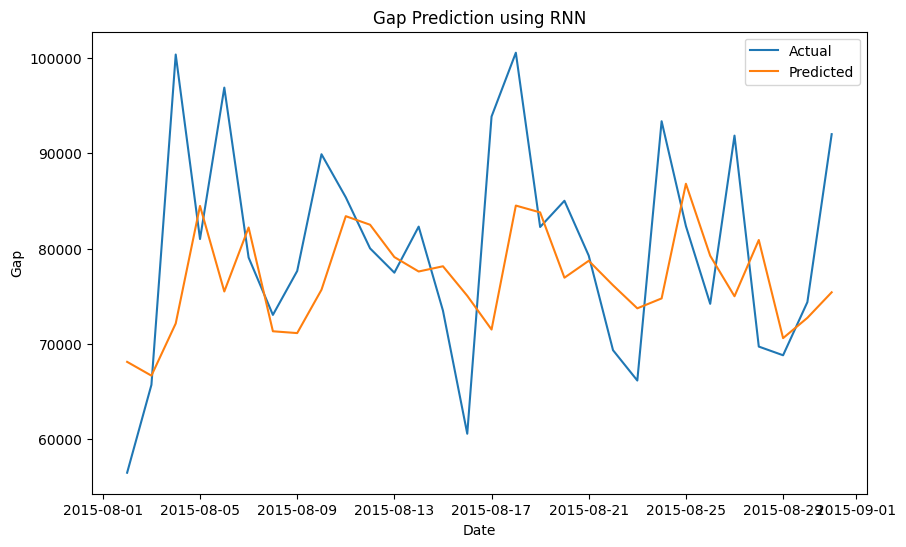

In [43]:
# Visualize predictions against actual data
df = input_data.df
train_size = input_data.train_size
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size + sequence_length :], y_test, label="Actual")
plt.plot(df.index[train_size + sequence_length :], y_pred, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Gap")
plt.title("Gap Prediction using RNN")
plt.legend()
plt.show()